# Abstract
## Purpose & Motivation

While going through the various research papers a concept was described of how to visualize syncronized flow which is when the speed of each lane is essentially the same.


## Direction from Advisor
N/A

## Tasks/Questions to Answer
### Questions to Answer
* Can we visually see syncronized flow

### Tasks
* Aggregate data for by lane analysis
* Visualize syncronized flow by graphing by lane data

## Conclusions
* 


In [1]:
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SparkSession

# Import data types
from pyspark.sql.types import *
from pyspark.sql.functions import minute, hour, concat, col, lit, Column

# sparkConf = SparkConf()
# sparkConf.set("spark.ui.port", "4050")

#     .config("spark.driver.allowMultipleContexts", "true") \

# spark = SparkSession \
#     .builder \
#     .appName("moreTrafficData") \
#     .getOrCreate()

In [2]:
import pandas as pd
from time import time
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import sklearn.ensemble
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble.iforest import IsolationForest
from sklearn.preprocessing import LabelEncoder
sns.set(style="whitegrid", color_codes=True)
%matplotlib inline

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Load Metadata

In [3]:
!head -n 5 ../../data/meta_2015_with_elev.csv

,Unnamed: 0,Unnamed: 0.1,ID,Fwy,Dir,District,County,City,State_PM,Abs_PM,Latitude,Longitude,Length,Type,Lanes,Name,User_ID_1,User_ID_2,User_ID_3,User_ID_4,file_date,elevation
0,0,0,1113072,56,W,11,73,66000.0,7.383,7.885,32.955202,-117.124689,0.452,ML,2,Black Mountain Rd,314,,,,2015_01_01,178.243728638
1,1,1,1113073,56,W,11,73,66000.0,7.383,7.885,32.955202,-117.124689,,OR,3,BLACK MOUNTAIN RD,314,,,,2015_01_01,178.243728638
2,2,2,1113680,56,E,11,73,66000.0,6.862,7.364,32.953394,-117.133404,0.999,ML,3,BLACK MOUNTAIN RD,434,,,,2015_01_01,150.936233521
3,3,3,1113683,56,W,11,73,66000.0,7.383,7.885,32.955202,-117.124689,,FR,2,BLK MOUNTAIN - WB 56,314,,,,2015_01_01,178.243728638


In [4]:
# loaded the data using spark (for fun...)
meta_data = spark.read.csv('../../data/meta_2015_with_elev.csv',
                           inferSchema='true',
                           header='true',
                           sep=',',
                           encoding='utf-8',
                           timestampFormat='MM/dd/yyyy HH:mm:ss',
                         )

In [5]:
meta_df = meta_data.toPandas()

In [6]:
# meta_df[meta_df.ID == 1122588]

In [7]:
def create_freeway_vectors(frame_to_use, columns_to_select=['ID', 'Latitude', 'Longitude', 'Abs_PM', 'Lanes']):
    to_loop = frame_to_use.groupby(['Fwy', 'Dir'])['ID'].count().reset_index()[['Fwy', 'Dir']].values
    
    ret = {}
    for Fwy, Dir in to_loop:
        tmp = frame_to_use[(frame_to_use.Fwy == Fwy) & (frame_to_use.Dir == Dir)
                                                  & (frame_to_use.Type == 'ML')]\
            .sort_values(by='Abs_PM', ascending=True)[columns_to_select].drop_duplicates()
        tmp['order'] = pd.Series(index=tmp.index, data=sorted(range(0, len(tmp.ID)), reverse=False))
        tmp['distance'] = tmp.Abs_PM - tmp.Abs_PM.shift(1)        
        tmp.loc[tmp['order'] == 0, 'distance'] = tmp[tmp['order'] == 0].Abs_PM
        ret["%s_%s" % (Fwy, Dir)] = tmp
    return ret 

In [8]:
freeway_vectors = create_freeway_vectors(meta_df)

# Load 5 Minute Data

## Read the results by time with by lane data

In [9]:
result_by_time = pd.read_csv('../../data/result_by_time.csv')

## Visualize individual lanes

In [10]:
result_by_time.columns

Index([u'Unnamed: 0', u'Station', u'TimeNumber', u'avg(avgspeed)',
       u'avg(lane1_avgspeed)', u'avg(lane1_flow)', u'avg(lane2_avgspeed)',
       u'avg(lane2_flow)', u'avg(lane3_avgspeed)', u'avg(lane3_flow)',
       u'avg(lane4_avgspeed)', u'avg(lane4_flow)', u'avg(lane5_avgspeed)',
       u'avg(lane5_flow)', u'avg(lane6_avgspeed)', u'avg(lane6_flow)',
       u'avg(lane7_avgspeed)', u'avg(lane7_flow)', u'avg(lane8_avgspeed)',
       u'avg(lane8_flow)', u'avg(perc_observed)', u'avg(samples)',
       u'avg(totalflow)', u'_c0', u'Unnamed: 0.1', u'Unnamed: 0.1', u'ID',
       u'Fwy', u'Dir', u'District', u'County', u'City', u'State_PM', u'Abs_PM',
       u'Latitude', u'Longitude', u'Length', u'Type', u'Lanes', u'Name',
       u'User_ID_1', u'User_ID_2', u'User_ID_3', u'User_ID_4', u'file_date',
       u'elevation'],
      dtype='object')

In [11]:
result_by_time.head()

,Unnamed: 0,Station,TimeNumber,avg(avgspeed),avg(lane1_avgspeed),avg(lane1_flow),avg(lane2_avgspeed),avg(lane2_flow),avg(lane3_avgspeed),avg(lane3_flow),...,Length,Type,Lanes,Name,User_ID_1,User_ID_2,User_ID_3,User_ID_4,file_date,elevation
0,0,1108417,0.0,69.470685,76.475616,8.805479,73.955068,24.290411,71.926027,30.580822,...,0.484,ML,5,5th Ave,10512,NaN,NaN,NaN,2015_12_17,46.761951
1,1,1108701,0.0,NaN,NaN,0.048571,NaN,3.311429,NaN,NaN,...,NaN,OR,2,WOODLAND PKWY,235,NaN,NaN,NaN,2015_12_17,196.762085
2,2,1108740,0.0,NaN,NaN,0.471429,NaN,0.697143,NaN,NaN,...,NaN,OR,2,CARMEL CREEK RD,14503,NaN,NaN,NaN,2015_12_17,22.299541
3,3,1113364,0.0,67.566849,71.199726,10.745205,65.094247,15.098630,NaN,NaN,...,2.785,ML,2,LAKE JENNINGS PK RD,496,NaN,NaN,NaN,2015_12_17,208.941895
4,4,1116575,0.0,NaN,NaN,17.224719,NaN,NaN,NaN,NaN,...,NaN,FF,1,5 NB Conn form 8WB,20306,NaN,NaN,NaN,2015_12_17,16.148054


In [24]:
graph_ready = {}
for freeway_key in freeway_vectors:
    Fwy, Dir = freeway_key.split('_')
    speed_columns = ['avg(lane1_avgspeed)', 'avg(lane2_avgspeed)', 'avg(lane3_avgspeed)', 'avg(lane4_avgspeed)',
                     'avg(lane5_avgspeed)', 'avg(lane6_avgspeed)', 'avg(lane7_avgspeed)', 'avg(lane8_avgspeed)']
    data = result_by_time[(result_by_time.Dir == Dir) & (result_by_time.Fwy == int(Fwy)) &
                          (result_by_time.Type == 'ML')].sort_values(
        by=['TimeNumber', 'Abs_PM'])[speed_columns + ['TimeNumber', 'Abs_PM']].set_index(['TimeNumber', 'Abs_PM'])
    to_concat = []
    for speed_col in speed_columns:
        tmp = data[speed_col].reset_index()
        tmp['lane'] = speed_col.split('(')[1].split('_')[0]
        tmp = tmp.rename(columns = {speed_col: 'value'})
        to_concat.append(tmp)
    variance = data.var(axis=1).reset_index().rename(columns = {0: 'value'})
    variance['lane'] = 'variance'
    to_concat.append(variance)  
    graph_ready[freeway_key] = pd.concat(to_concat)

In [25]:
# for freeway_key in freeway_vectors:
#     data = graph_ready['125_S']
#     kws = dict(s=50, linewidth=.5, edgecolor="w")
#     g = sns.FacetGrid(data, col="TimeNumber", hue="lane", palette="Set1")
# #                       hue_order=["Dinner", "Lunch"])
# #     g = (g.map(sns.pointplot, "total_bill", "tip", **kws)
# #          .add_legend())
#     break


In [26]:
# kws = dict(s=50, linewidth=.5, edgecolor="w")
# g = sns.FacetGrid(tips, col="TimeNumber", hue="time", palette="Set1",
#                   hue_order=["Dinner", "Lunch"])
# g = (g.map(sns.pointplot, "total_bill", "tip", **kws)
#      .add_legend())

In [29]:
data = graph_ready['5_S'].dropna()
data.head()

,TimeNumber,Abs_PM,value,lane
0,0.0,1.140,74.780822,lane1
1,0.0,1.291,75.753973,lane1
2,0.0,2.186,74.775890,lane1
3,0.0,2.559,73.983014,lane1
4,0.0,3.336,74.777808,lane1


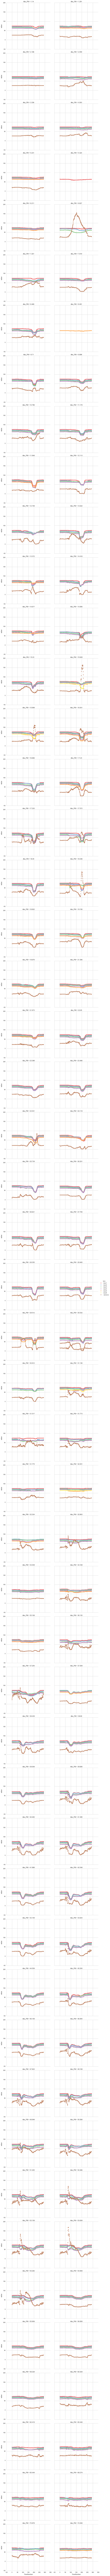

In [30]:
kws = dict(s=50, linewidth=.5, edgecolor="w")
g = sns.FacetGrid(data, col="Abs_PM", hue="lane", palette="Set1", col_wrap=2, size=5)
g = (g.map(plt.scatter, "TimeNumber", "value", edgecolor="w")
     .add_legend())